**Распаковка архива**

In [59]:
# !unzip -q "im.zip"

In [60]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()

****Подключаем CUDA****

In [61]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device("cuda:0")

**Загружаем датасеты и создаем loader'ы**

In [62]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными
data_dir = r'./im'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

**Узнаем размеры тестовой и обучающей выборки**

In [63]:
print(dataset_sizes)

{'train': 2198, 'test': 500}


**Количество классов**

In [64]:
print(class_names)

['Chips', 'Chocolate', 'Deo', 'Milk', 'Shampoo']


**Визуализируем 4 случайных объекта обучающей выборки**

tensor([1, 4, 2, 3])


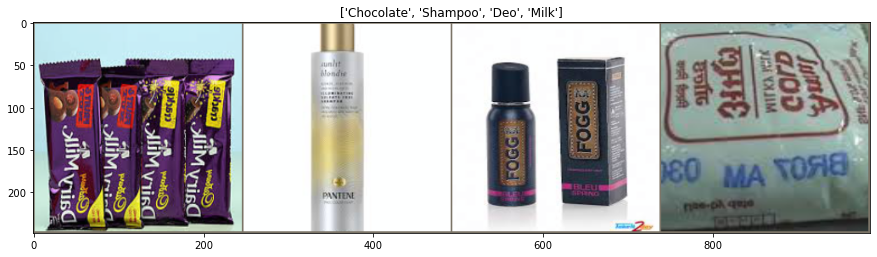

In [65]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))
print(classes)
# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [66]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.to(device)
    #best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'test']:
            if phase == 'train':
#                 scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [67]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [68]:
def evaluate(model):
    model.train(False)
    
    runninig_correct = 0
    for data in dataloaders['test']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['test']

**Своя свёрточная нейросеть для предсказания**

In [69]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=5).cuda()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.fc1 = nn.Linear(120 * 50 * 120, 100).cuda()
        self.fc2 = nn.Linear(100, 5).cuda()
        self.norm6 = nn.BatchNorm2d(50).cuda()
        self.norm30 = nn.BatchNorm2d(30).cuda()
        self.norm70 = nn.BatchNorm2d(150).cuda()
        
    def forward(self, x):            
        x = self.pool(F.relu(self.norm6(self.conv1(x))))
        #print(x.shape)
        x = x.view(-1, 120 * 120 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [70]:
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F  

In [71]:
loss_train = []  # для построения графиков
loss_test = []   # для построения графиков

# объявляем сеть
net = SimpleConvNet()
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-5
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(3)):  

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(dataloaders['train'])):   # для train
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    e_loss_train = running_loss / len(dataloaders['train'].dataset)
    loss_train.append(e_loss_train)

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(dataloaders['test'])):  # для теста
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()
    e_loss_test = running_loss / len(dataloaders['test'].dataset)
    loss_test.append(e_loss_test)
print('Обучение закончено')



Обучение закончено


**Среднее качество обучения**

In [72]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
p = 0
with torch.no_grad():
    for data in dataloaders['test']:
        p = p + 1
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


ob = 0

classes = image_datasets['train'].classes
for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    ob = ob + 100 * class_correct[i] / class_total[i]
print('Accuracy: {:.2f}%'.format(ob / 5))

Accuracy of Chips : 81 %
Accuracy of Chocolate : 81 %
Accuracy of   Deo : 34 %
Accuracy of  Milk : 53 %
Accuracy of Shampoo : 68 %
Accuracy: 63.40%


**Визуализируем объекты тестовой выборки и их предсказания**

In [73]:
from torch.autograd import Variable

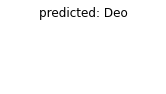

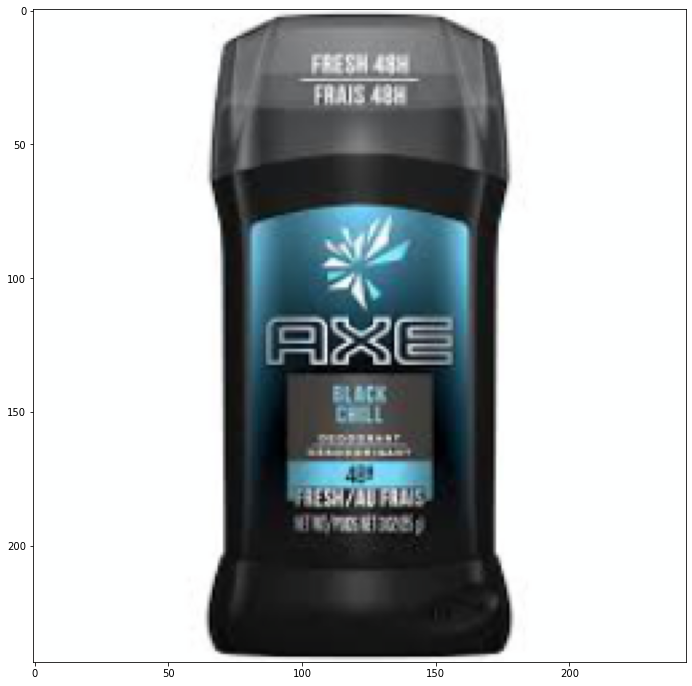

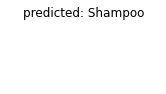

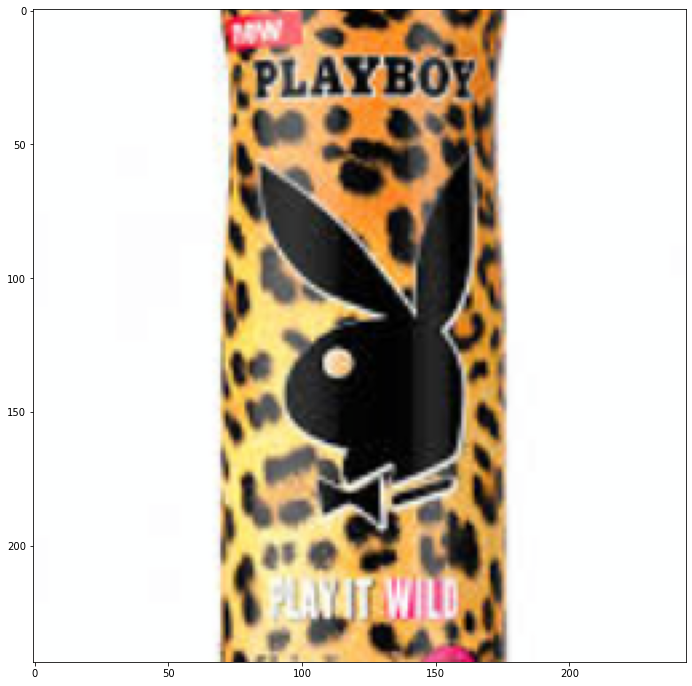

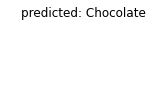

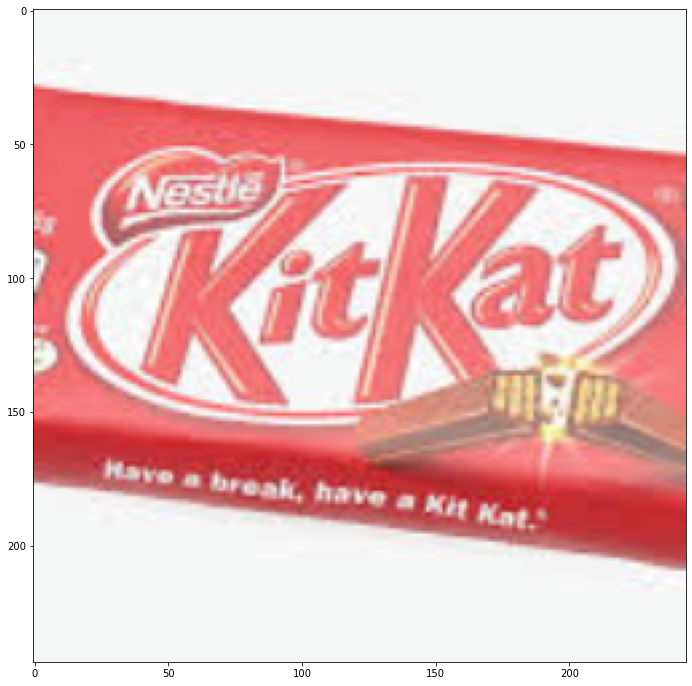

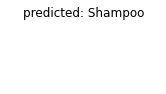

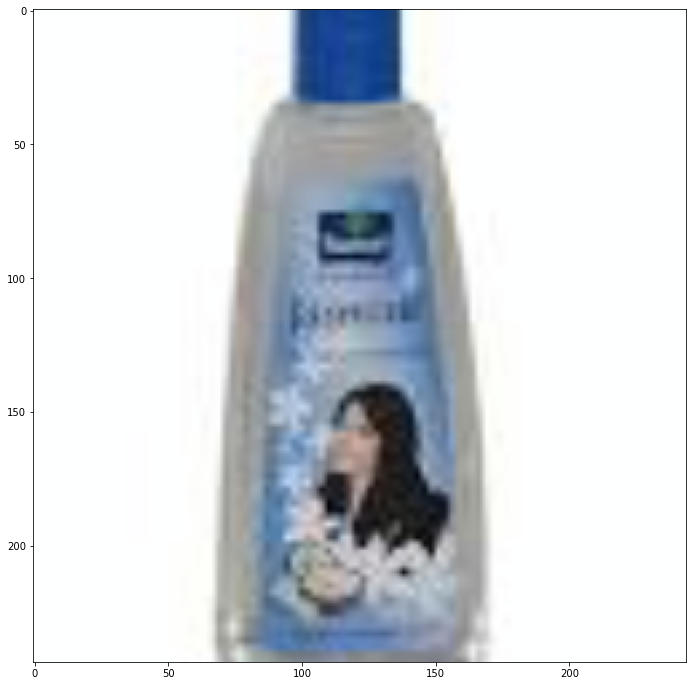

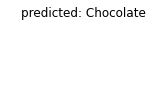

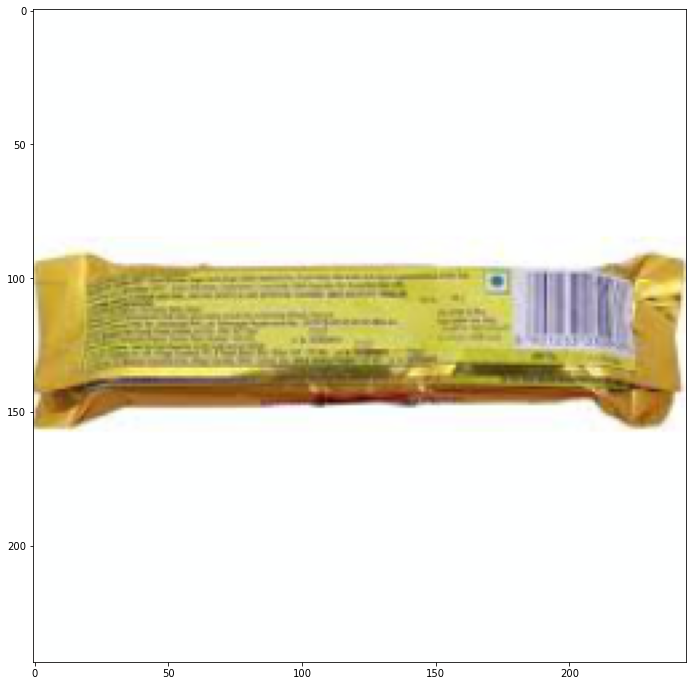

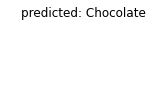

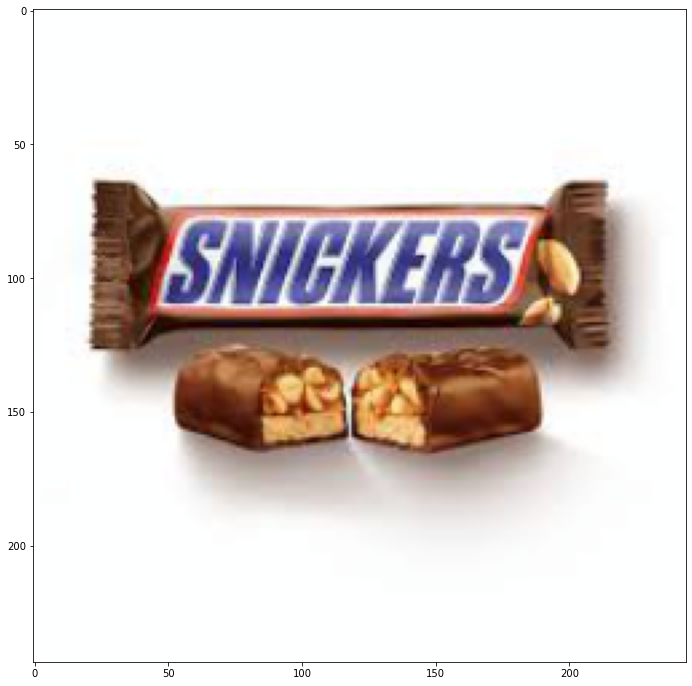

In [74]:
visualize_model(net)

**Строим графики**

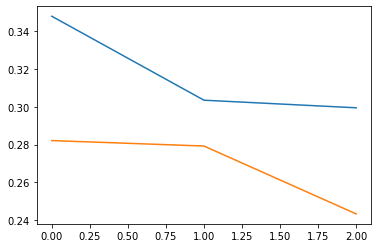

In [75]:
plt.plot(loss_train)
plt.plot(loss_test)

**Оптимизируем свою сверточную сеть**

In [77]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=4).cuda()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2).cuda()
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=4).cuda()
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=150, kernel_size=4).cuda()

        self.fc1 = nn.Linear(27 * 150 * 27, 500).cuda()
        self.fc2 = nn.Linear(500, 300).cuda()
        self.fc3 = nn.Linear(300, 100).cuda()
        self.fc4 = nn.Linear(100, 5).cuda()
        self.norm6 = nn.BatchNorm2d(50).cuda()
        self.norm30 = nn.BatchNorm2d(30).cuda()
        self.norm70 = nn.BatchNorm2d(150).cuda()

    def forward(self, x):
        x = x.to(device)
        x = self.pool(F.relu(self.norm6(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.norm70(self.conv3(x))))
        #print(x.shape)
        x = x.view(-1, 27 * 27 * 150)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [78]:
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F  

In [79]:
loss_train = []  # для построения графиков
loss_test = []   # для построения графиков

# объявляем сеть
net = SimpleConvNet()
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-5
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(10)):  

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(dataloaders['train'])):   # для train
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    e_loss_train = running_loss / len(dataloaders['train'].dataset)
    loss_train.append(e_loss_train)

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(dataloaders['test'])):  # для теста
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()
    e_loss_test = running_loss / len(dataloaders['test'].dataset)
    loss_test.append(e_loss_test)
    
print('Обучение закончено')



Обучение закончено


**Среднее качество обучения**

In [102]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
p = 0
with torch.no_grad():
    for data in dataloaders['test']:
        p = p + 1
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


ob = 0
for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    ob = ob + 100 * class_correct[i] / class_total[i]
print('Accuracy: {:.2f}%'.format(ob / 5))

Accuracy of Chips : 89 %
Accuracy of Chocolate : 77 %
Accuracy of   Deo : 93 %
Accuracy of  Milk : 71 %
Accuracy of Shampoo : 70 %
Accuracy: 80.00%


**Строим графики**

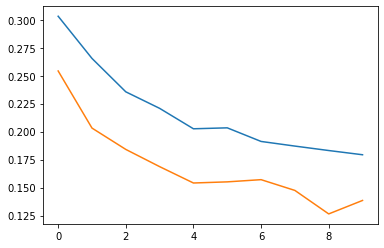

In [81]:
plt.plot(loss_train)
plt.plot(loss_test)

**Визуализируем объекты тестовой выборки и их предсказания**

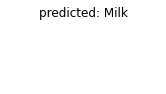

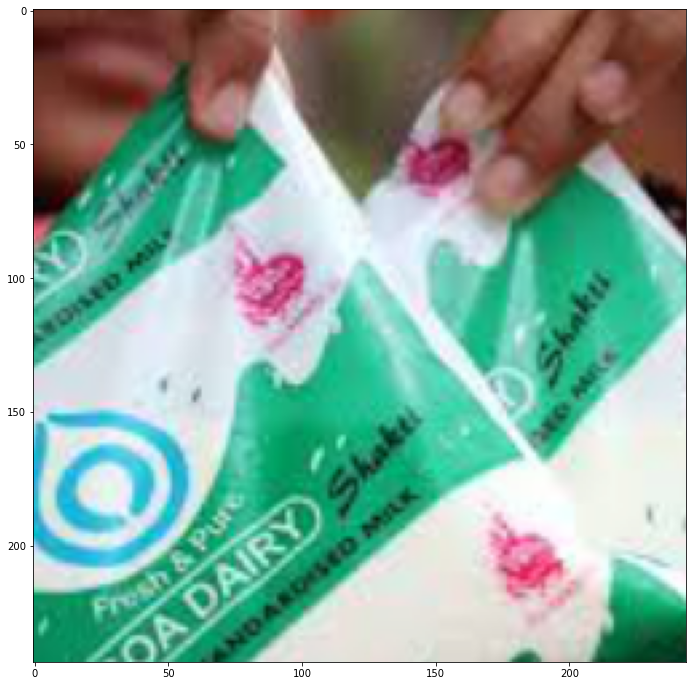

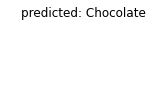

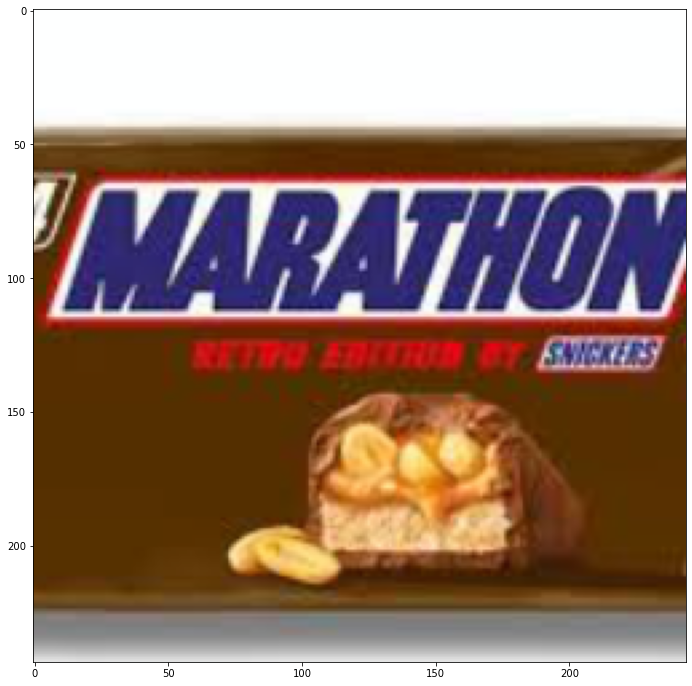

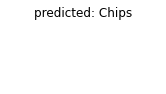

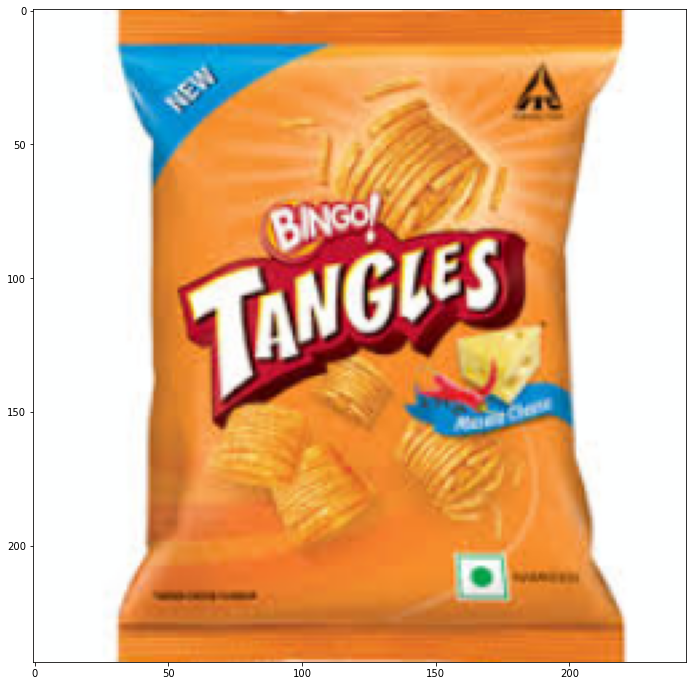

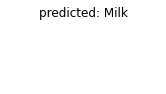

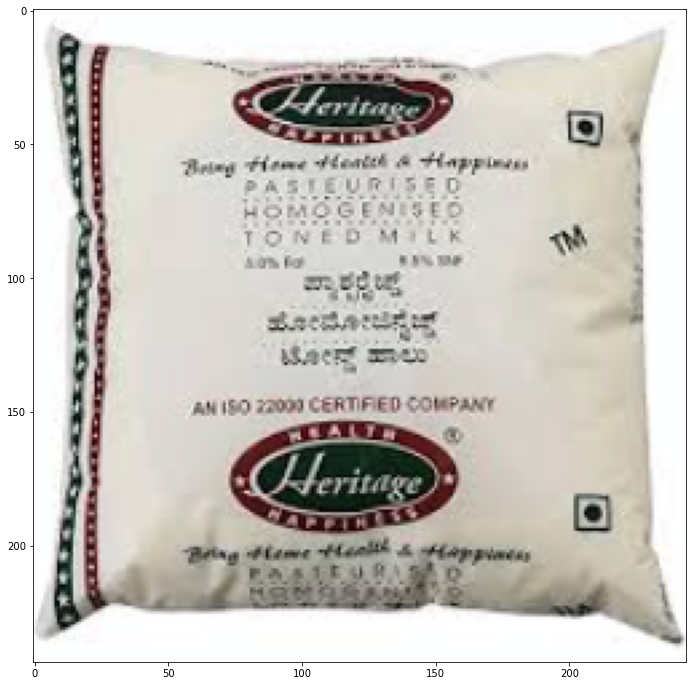

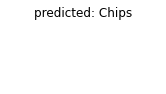

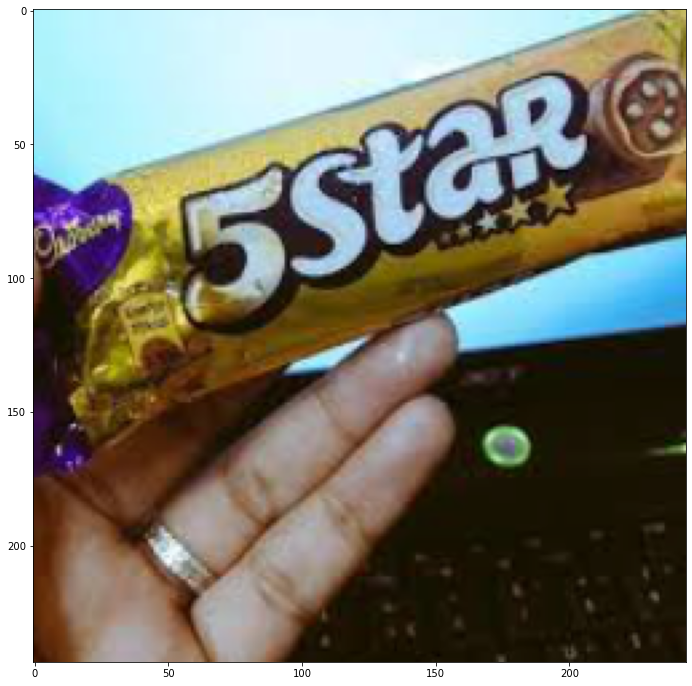

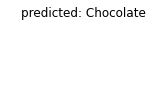

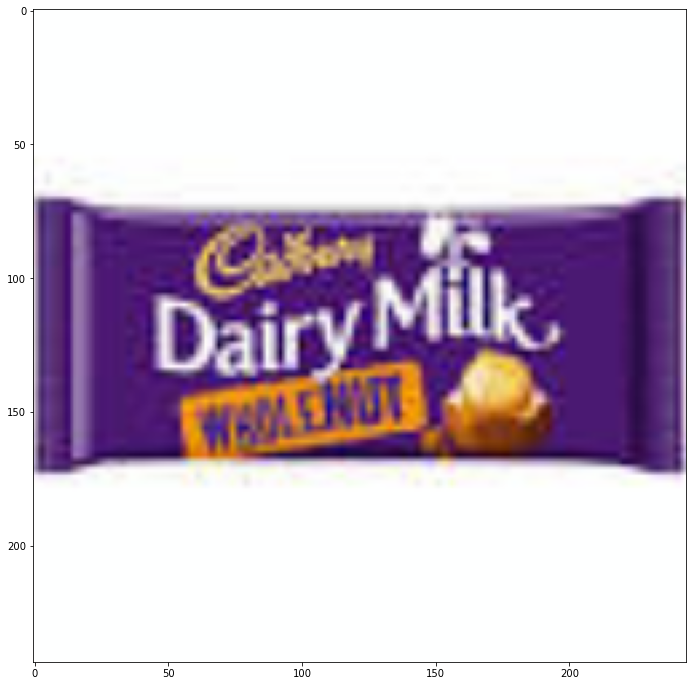

In [82]:
visualize_model(net)

**Применим технологию transfer learning**

In [83]:
# Ваш код здесь
model_extractor = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 5)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [84]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5859 Acc: 0.7634
test Loss: 0.1989 Acc: 0.9220

Epoch 1/4
----------
train Loss: 0.4058 Acc: 0.8494
test Loss: 0.2173 Acc: 0.9240

Epoch 2/4
----------
train Loss: 0.4141 Acc: 0.8703
test Loss: 0.1611 Acc: 0.9320

Epoch 3/4
----------
train Loss: 0.3436 Acc: 0.8799
test Loss: 0.1061 Acc: 0.9640

Epoch 4/4
----------
train Loss: 0.3697 Acc: 0.8885
test Loss: 0.2132 Acc: 0.9380

Training complete in 1m 30s
Best val Acc: 0.964000


**Cреднее качество обучения**

In [85]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9380


**Графики loss-функции**

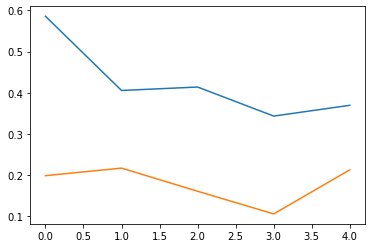

In [86]:
plt.plot(losses['train'])
plt.plot(losses['test'])

**Визуализируем объекты тестовой выборки и их предсказания**

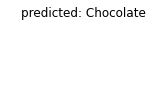

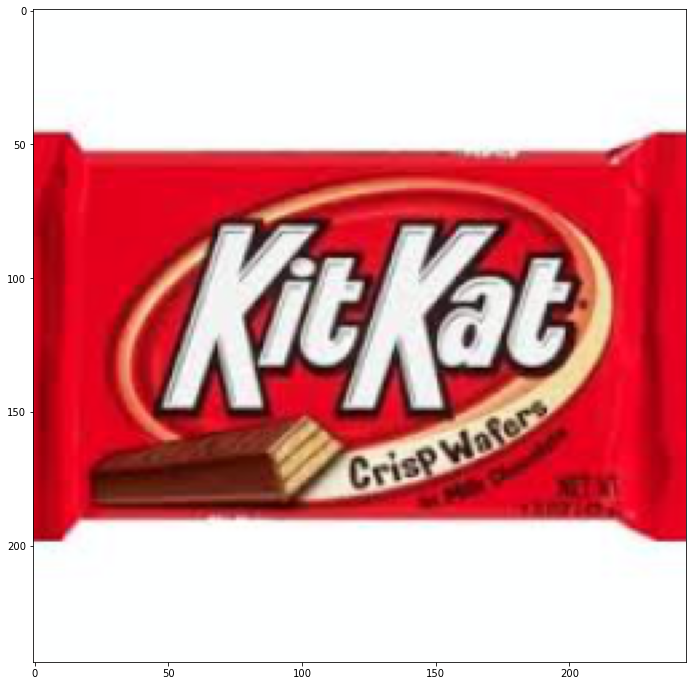

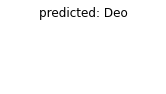

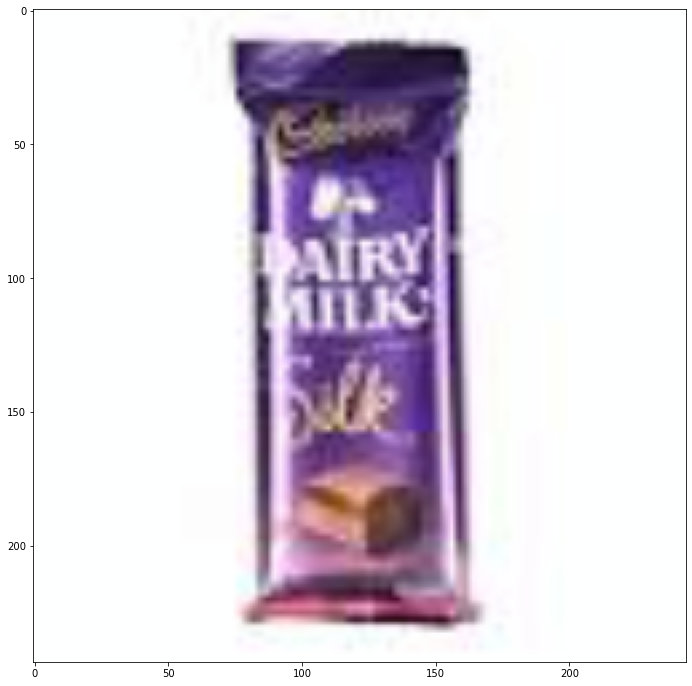

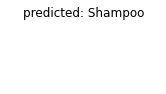

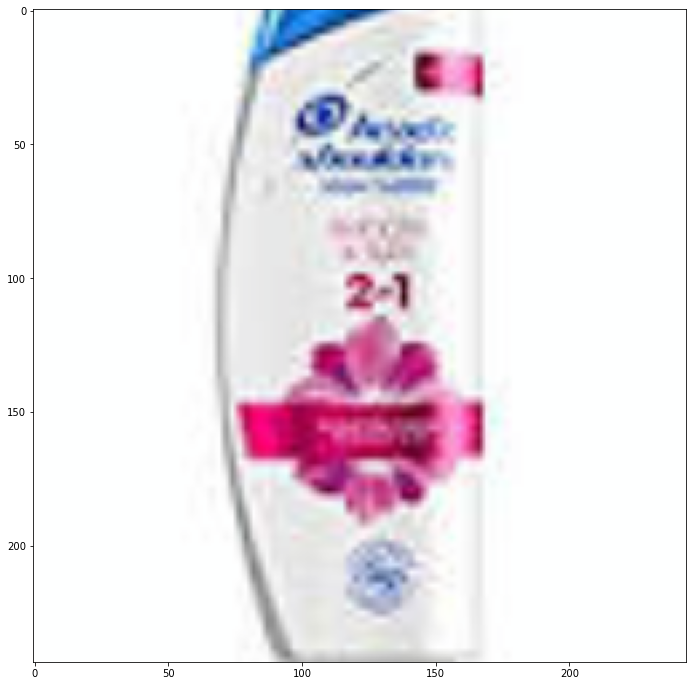

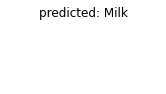

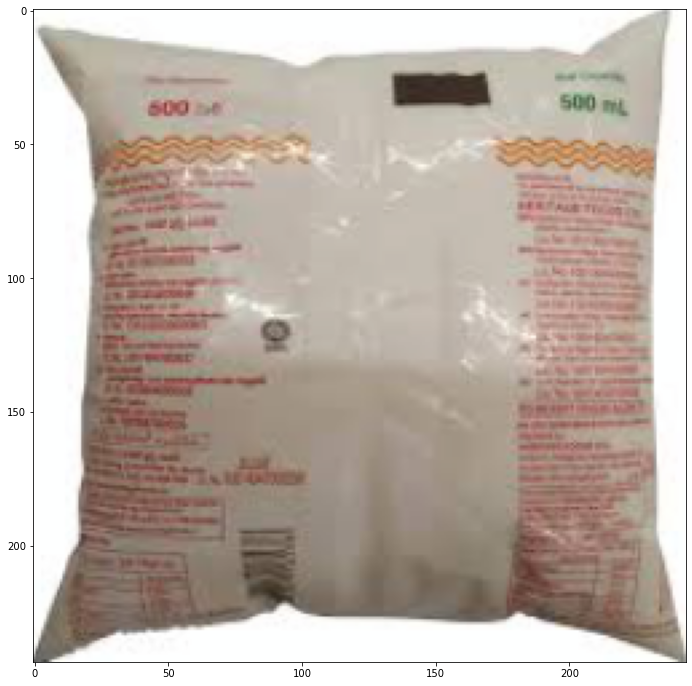

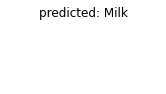

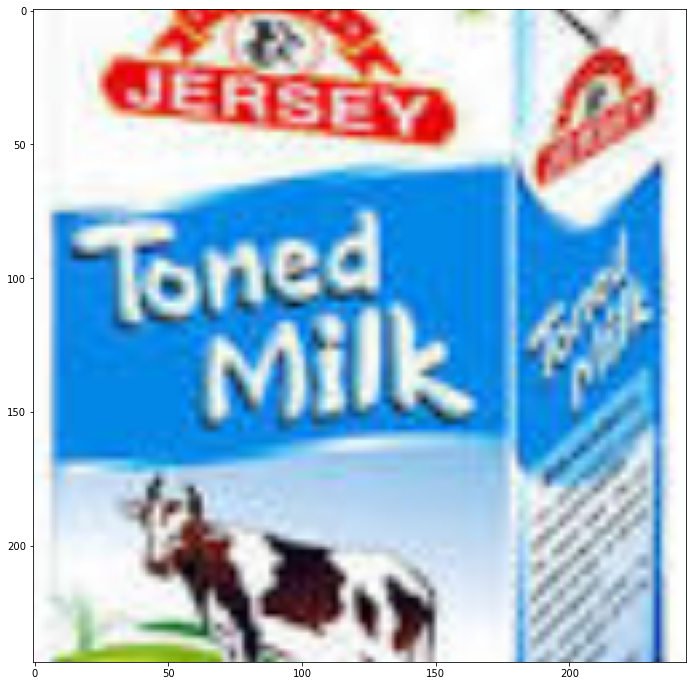

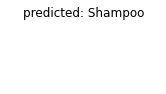

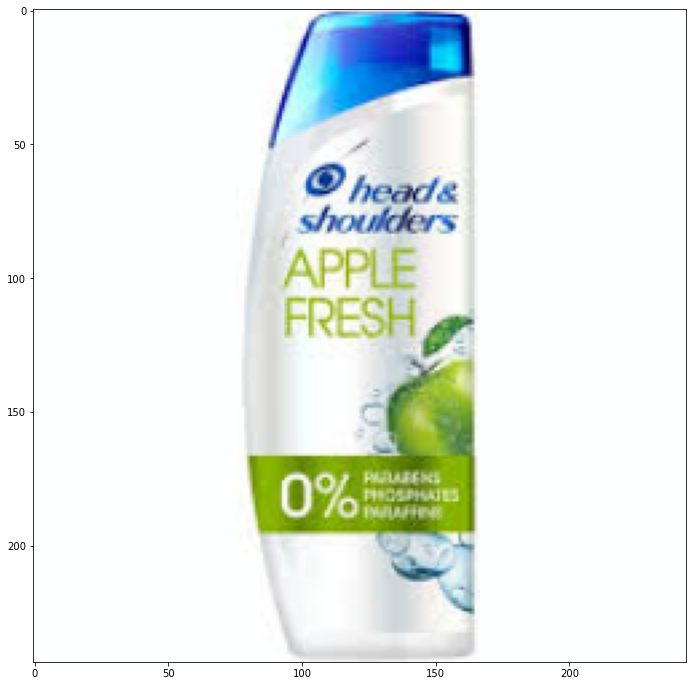

In [87]:
visualize_model(net)

**Выводы:**

**Первая нейронная сеть показала точность 0.6340. Резульат удалось улучшить, добавив дополнительные сверточные слои, нормализацию, увеличив количество нейронов во всех слоях и количество эпох. Новый результат: 0.8000**

**Применив transfer learning удалось увеличить точность до 0.9380**